In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Load training and test datasets
train_path = "/kaggle/input/energy-consumption-dataset-linear-regression/train_energy_data.csv"
test_path = "/kaggle/input/energy-consumption-dataset-linear-regression/test_energy_data.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

print("\nTraining Data Preview:")
display(train_df.head())

print("\nTesting Data Preview:")
display(test_df.head())


Training Data Shape: (1000, 7)
Testing Data Shape: (100, 7)

Training Data Preview:


,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,7063,76,10,29.84,Weekday,2713.95
1,Commercial,44372,66,45,16.72,Weekday,5744.99
2,Industrial,19255,37,17,14.30,Weekend,4101.24
3,Residential,13265,14,41,32.82,Weekday,3009.14
4,Commercial,13375,26,18,11.92,Weekday,3279.17



Testing Data Preview:


,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,24563,15,4,28.52,Weekday,2865.57
1,Commercial,27583,56,23,23.07,Weekend,4283.80
2,Commercial,45313,4,44,33.56,Weekday,5067.83
3,Residential,41625,84,17,27.39,Weekend,4624.30
4,Residential,36720,58,47,17.08,Weekday,4820.59


In [5]:
print("Training Data Info:")
print(train_df.info())

print("\nMissing Values:")
print(train_df.isnull().sum())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       1000 non-null   int64  
 2   Number of Occupants  1000 non-null   int64  
 3   Appliances Used      1000 non-null   int64  
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 54.8+ KB
None

Missing Values:
Building Type          0
Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Day of Week            0
Energy Consumption     0
dtype: int64


In [6]:
# Combine train and test for consistent encoding
combined_df = pd.concat([train_df, test_df], axis=0)

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Building Type', 'Day of Week']

for col in categorical_columns:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col])
    label_encoders[col] = le

# Split back into train and test
train_encoded = combined_df.iloc[:len(train_df)]
test_encoded = combined_df.iloc[len(train_df):]

train_encoded.head()


,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,2,7063,76,10,29.84,0,2713.95
1,0,44372,66,45,16.72,0,5744.99
2,1,19255,37,17,14.30,1,4101.24
3,2,13265,14,41,32.82,0,3009.14
4,0,13375,26,18,11.92,0,3279.17


In [7]:
#Feature Selection

feature_cols = ['Building Type', 'Square Footage', 'Number of Occupants', 
                'Appliances Used', 'Average Temperature', 'Day of Week']

X_train = train_encoded[feature_cols]
y_train = train_encoded['Energy Consumption']

X_test = test_encoded[feature_cols]
y_test = test_encoded['Energy Consumption']

print("Features Shape:", X_train.shape)
print("Target Shape:", y_train.shape)


Features Shape: (1000, 6)
Target Shape: (1000,)


In [9]:
#Normalize Numerical Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
#Train a Random Forest Regressor

# Build and train model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
train_preds = model.predict(X_train_scaled)
test_preds = model.predict(X_test_scaled)

# Show sample predictions vs actual
sample_results = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': test_preds[:10]
})
print("Sample predictions on test data:")
display(sample_results)


Sample predictions on test data:


,Actual,Predicted
0,2865.57,2994.11310
1,4283.80,4291.34005
2,5067.83,5214.19775
3,4624.30,4683.08275
4,4820.59,4727.77580
5,5026.23,4995.58155
6,4404.56,4551.77615
7,2394.37,2404.47570
8,3969.09,4038.81875
9,5136.69,4939.83975


In [13]:
#Evaluate Model Performance
def evaluate_model(true, pred, dataset_name="Dataset"):
    rmse = mean_squared_error(true, pred, squared=False)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{dataset_name} Evaluation:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R2 Score: {r2:.2f}")
    print("-"*40)

# Evaluate on both train and test
evaluate_model(y_train, train_preds, "Train")
evaluate_model(y_test, test_preds, "Test")


Train Evaluation:
  RMSE: 45.38
  MAE: 35.75
  R2 Score: 1.00
----------------------------------------
Test Evaluation:
  RMSE: 116.25
  MAE: 93.29
  R2 Score: 0.98
----------------------------------------


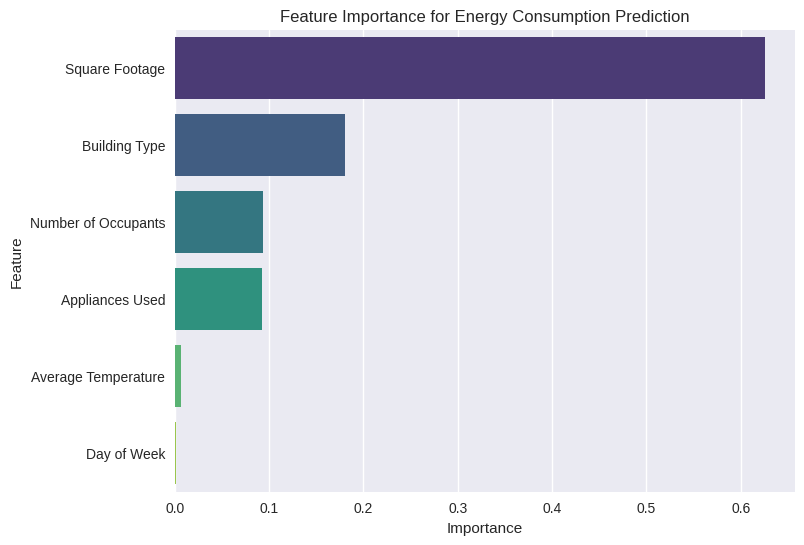

,Feature,Importance
1,Square Footage,0.625925
0,Building Type,0.180014
2,Number of Occupants,0.094020
3,Appliances Used,0.092702
4,Average Temperature,0.006136
5,Day of Week,0.001204


In [14]:
#Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance for Energy Consumption Prediction")
plt.show()

feature_importance_df


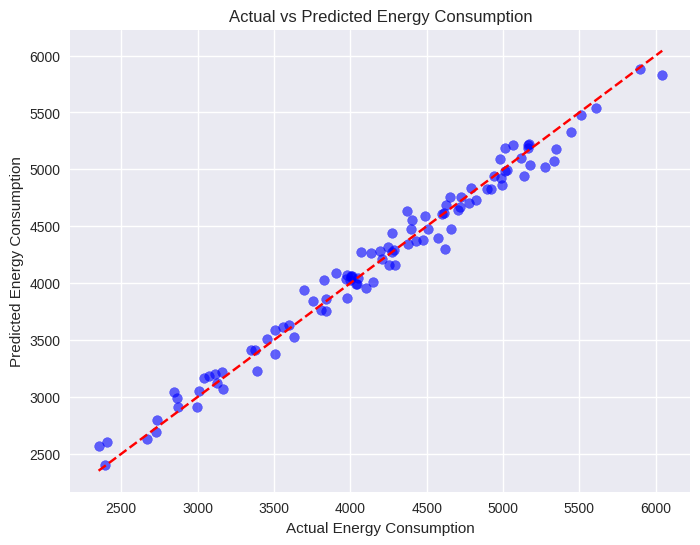

In [15]:
#Visualization of Predictions vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, test_preds, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs Predicted Energy Consumption")
plt.show()


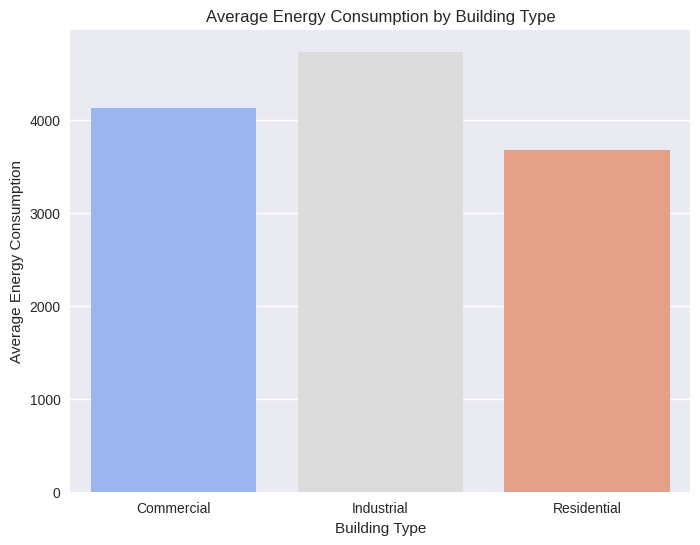

Building Type
Commercial     4130.023571
Industrial     4735.142618
Residential    3681.626628
Name: Energy Consumption, dtype: float64

In [16]:
#Grouped Analysis by Building Type
# Reverse encode building type for visualization
train_df['Building Type'] = label_encoders['Building Type'].inverse_transform(train_encoded['Building Type'])

avg_consumption = train_df.groupby('Building Type')['Energy Consumption'].mean()

plt.figure(figsize=(8,6))
sns.barplot(x=avg_consumption.index, y=avg_consumption.values, palette='coolwarm')
plt.title("Average Energy Consumption by Building Type")
plt.xlabel("Building Type")
plt.ylabel("Average Energy Consumption")
plt.show()

avg_consumption


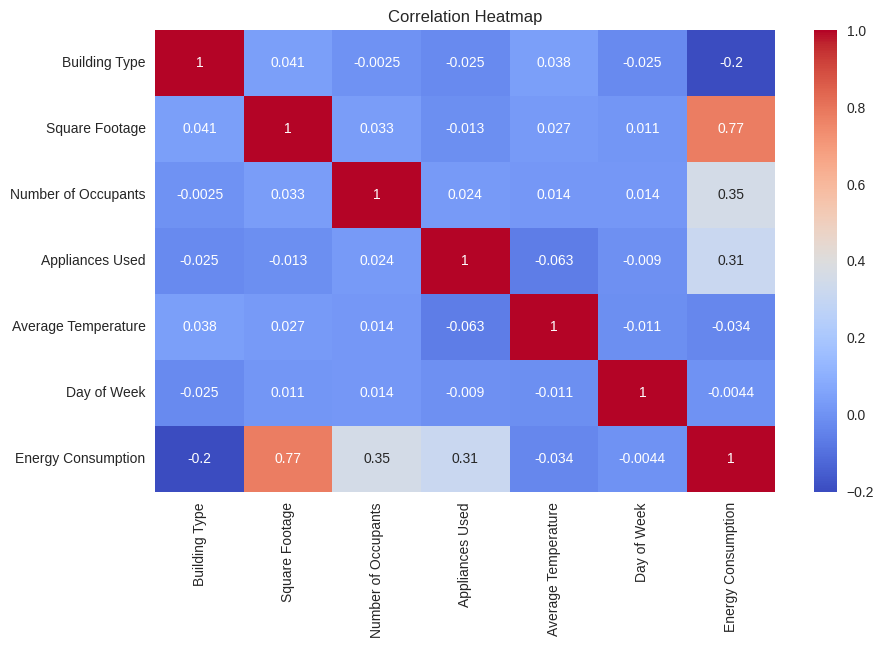

In [17]:
#Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(train_encoded[feature_cols + ['Energy Consumption']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [18]:
#Export Predictions
# Save predictions for test data
test_results = test_df.copy()
test_results['Predicted Energy Consumption'] = test_preds

test_results.to_csv("energy_predictions.csv", index=False)
print("Predictions exported to 'energy_predictions.csv'")


Predictions exported to 'energy_predictions.csv'
